In [10]:
import os
os.chdir('..')
from notebooks import config
import numpy as np
import torch
import time
import random
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from model.seg_model.unet import unet
from utils.metric import oa_binary, miou_binary
from utils.plot_dset_one import plot_dset_one
from dataloader.read_normalize import read_normalize
from model.seg_model.deeplabv3_plus import deeplabv3plus, deeplabv3plus_imp
from dataloader.parallel_loader import threads_scene_dset
from dataloader.loader import patch_tensor_dset
from utils.imgShow import imgShow
import glob



In [2]:
# ----------Data paths-------------- #
paths_as = sorted(glob.glob(config.root+'/data/s1_ascend/*'))
paths_des = sorted(glob.glob(config.root+'/data/s1_descend/*'))
paths_truth = sorted(glob.glob(config.root+'/data/s1_truth/*'))


In [3]:
### -----data read & pre-processing------- ###
scene_list, truth_list = read_normalize(paths_as=paths_as,\
                                    paths_des=paths_des, paths_truth=paths_truth)
len(scene_list)


20

### Multi-threading loading


In [5]:
threads_tra_dset = threads_scene_dset(scene_list[0:15], \
                                    truth_list[0:15], config.transforms_tra,num_thread=10)
print(threads_tra_dset.__len__())
threads_tra_loader = torch.utils.data.DataLoader(threads_tra_dset, \
                                        batch_size=4, shuffle=True, num_workers=0)


150


In [70]:
import torch.nn.functional as F

def convert_g_l(img_g, scale_ratio):
    '''global_size should be divisible by local_size.
    '''
    size_g = img_g.shape[2]
    size_l = size_g//scale_ratio
    if size_l >= 1:
        ''' crop -> enlarge scale '''
        start_crop = (size_g - size_l)//2
        img_l_crop = img_g[:,:, start_crop:start_crop+size_l, start_crop:start_crop+size_l]
        img_l = F.interpolate(img_l_crop, size=[size_g, size_g], mode='nearest')

    else:
        ''' enlarge scale -> crop '''
        start_crop = (size_g*scale_ratio - size_l*scale_ratio)//2
        img_g_up = F.interpolate(img_g, size=[size_g*scale_ratio, size_g*scale_ratio], mode='nearest')
        img_l = img_g_up[:, :, start_crop:start_crop+size_l*scale_ratio, start_crop:start_crop+size_l*scale_ratio]

    return img_l



### Comparison

In [69]:
for patch, truth in threads_tra_loader:
    # print(patch[0].shape)
    pass


In [65]:
patch[0].shape

torch.Size([2, 4, 16, 16])

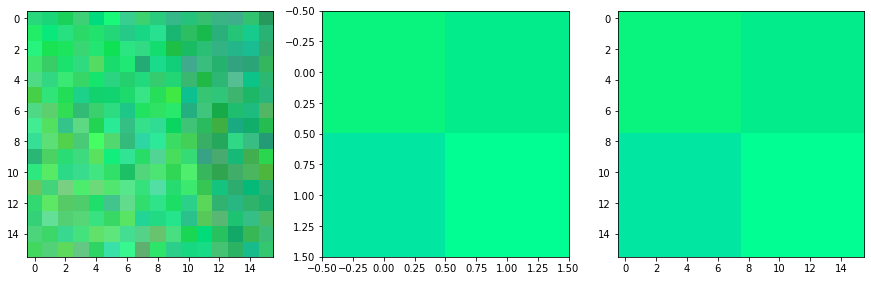

In [74]:
patch[0] = patch[0][:,:,0:16,0:16]

plt.figure(figsize=(15,5))
plt.subplot(131)
imgShow(patch[0][0].numpy().transpose(1,2,0), clip_percent=0)

plt.subplot(132)
imgShow(patch[0][0].numpy().transpose(1,2,0)[7:9,7:9,:], clip_percent=0)

patch_l = convert_g_l(patch[0], 8)
plt.subplot(133)
imgShow(patch_l[0].numpy().transpose(1,2,0), clip_percent=0)
